# CONTENTS

1. IMPORTING LIBRARIES/DATA

2. DATA OVERVIEW

3. DATA PREPROCESSING

    3a. SUBSETTING

    3b. WRANGLING
    
    3c. CONSISTENCY ASSESSMENT

4. TIME-SERIES ANALYSIS

    4a. DECOMPOSITION

    4b. TESTING FOR STATIONARITY

    4c. STATIONARIZATION

# IMPORTING LIBRARIES/DATA

In [1]:
# import libraries
import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import os
import statsmodels.api as sm # import public version of statsmodels

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight') # styling option for plots

import warnings
warnings.filterwarnings('ignore') # disable warnings

In [2]:
# configure API key
quandl.ApiConfig.api_key = '2sKZxgJoVyqnYsJxg3Rk'

In [3]:
# import Federal Reserve Economic Data "Housing Starts: Total: New Privately Owned Housing Units Started" variable
data = quandl.get('FRED/HOUST')

# DATA OVERVIEW

In [4]:
# first 5 rows
data.head()

,Value
Date,
1959-01-01,1657.0
1959-02-01,1667.0
1959-03-01,1620.0
1959-04-01,1590.0
1959-05-01,1498.0


In [5]:
# last 5 rows
data.tail()

,Value
Date,
2021-08-01,1573.0
2021-09-01,1550.0
2021-10-01,1552.0
2021-11-01,1678.0
2021-12-01,1702.0


In [6]:
# DataFrame size
data.shape

(756, 1)

In [7]:
# DataFrame columns
data.columns

Index(['Value'], dtype='object')

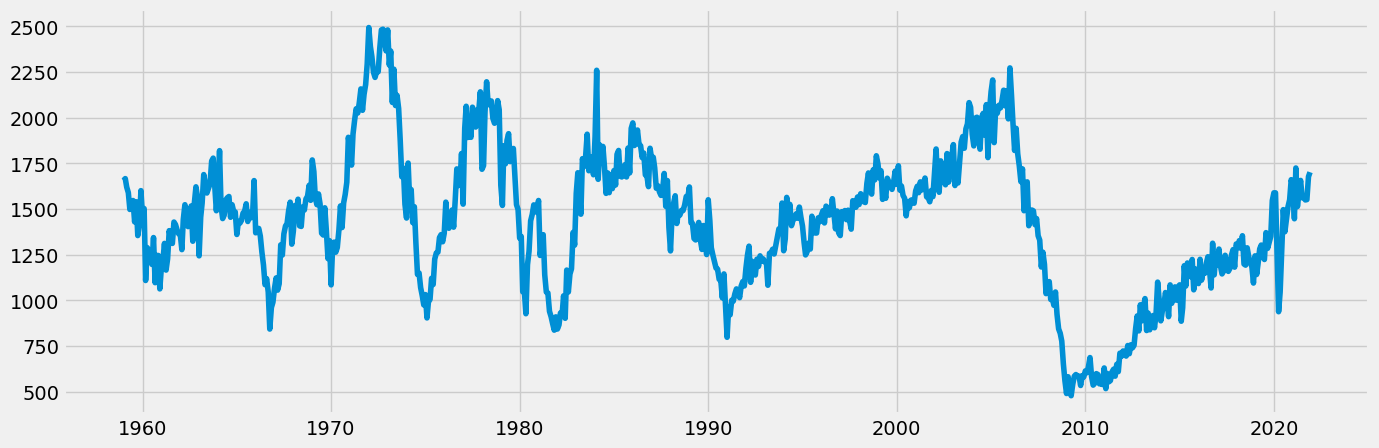

In [8]:
# plot data as a line chart
plt.figure(figsize=(15,5), dpi=100) 
plt.plot(data)

# DATA PREPROCESSING

## SUBSETTING

In [9]:
# reset index to allow the use of 'Date' as filter
data_2 = data.reset_index()

In [10]:
# first 5 rows
data_2.head()

,Date,Value
0,1959-01-01,1657.0
1,1959-02-01,1667.0
2,1959-03-01,1620.0
3,1959-04-01,1590.0
4,1959-05-01,1498.0


In [11]:
# intialize subset DataFrame
data_sub = data_2.loc[data_2['Date'] >= '2008-08-01']

In [12]:
# subset DataFrame size
data_sub.shape

(161, 2)

In order to refine the scope of my analysis, I carefully selected a specific data subset that spans from the inception of Airbnb in August 2008 to the most recent recorded observation in December 2021. The intention behind this selection is to draw attention to the patterns and tendencies within construction activity in the privately owned housing market subsequent to Airbnb's establishment.

## WRANGLING

In [13]:
# first 5 rows
data_sub.head()

,Date,Value
595,2008-08-01,844.0
596,2008-09-01,820.0
597,2008-10-01,777.0
598,2008-11-01,652.0
599,2008-12-01,560.0


In [14]:
# set 'Date' column as index

from datetime import datetime

data_sub['datetime'] = pd.to_datetime(data_sub['Date']) # generate datetime column from 'Date'
data_sub = data_sub.set_index('datetime') # set datetime as DataFrame index
data_sub.drop(['Date'], axis=1, inplace=True) # drop 'Date' column
data_sub.head()

,Value
datetime,
2008-08-01,844.0
2008-09-01,820.0
2008-10-01,777.0
2008-11-01,652.0
2008-12-01,560.0


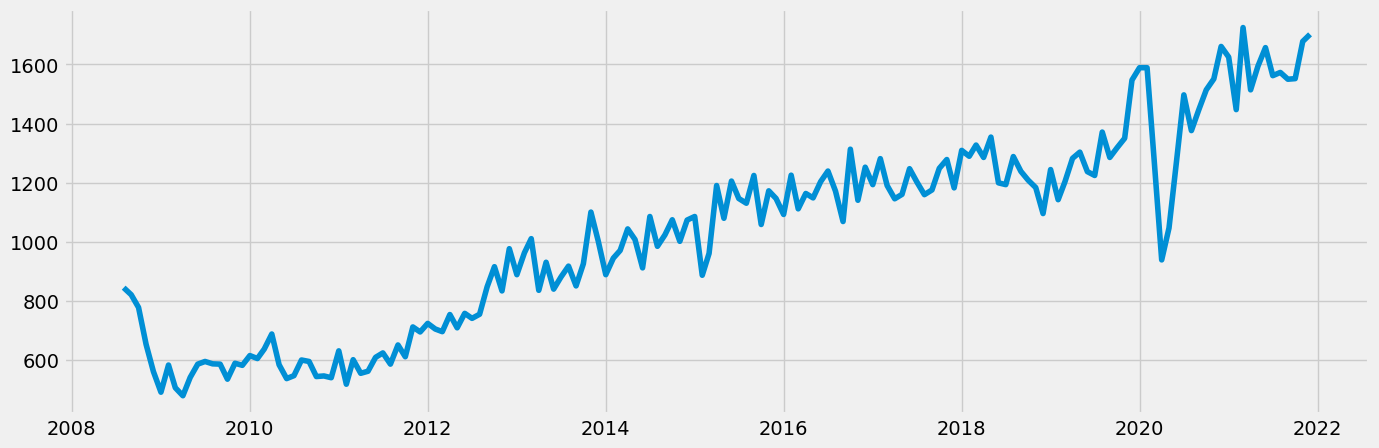

In [15]:
# plot wrangled DataFrame
plt.figure(figsize=(15, 5), dpi=100)
plt.plot(data_sub)

## CONSISTENCY ASSESSMENT

In [16]:
# identify missing values
data_sub.isnull().sum()

Value    0
dtype: int64

In [17]:
# identify full duplicates
dups_mask = data_sub.duplicated(keep=False)

# output full duplicates
dups = data_sub[dups_mask]
dups

,Value
datetime,
2009-06-01,585.0
2009-07-01,594.0
2009-09-01,585.0
2010-09-01,594.0
2011-08-01,585.0
2013-01-01,888.0
2014-01-01,888.0
2014-07-01,1085.0
2015-01-01,1085.0


The full-duplicate assessment has seemingly pinpointed multiple instances of duplicated observations. However, this assumption is inaccurate. While it is true that the 'Value' variable contains duplicate values, it's important to note that the corresponding dates are actually distinct. Consequently, there are no instances of duplication present within this dataset.

# TIME-SERIES ANALYSIS

## DECOMPOSITION

In [18]:
# decompose time series using additive model
decomposition = sm.tsa.seasonal_decompose(data_sub, model='additive')

In [19]:
# define a fixed size for all special charts

from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

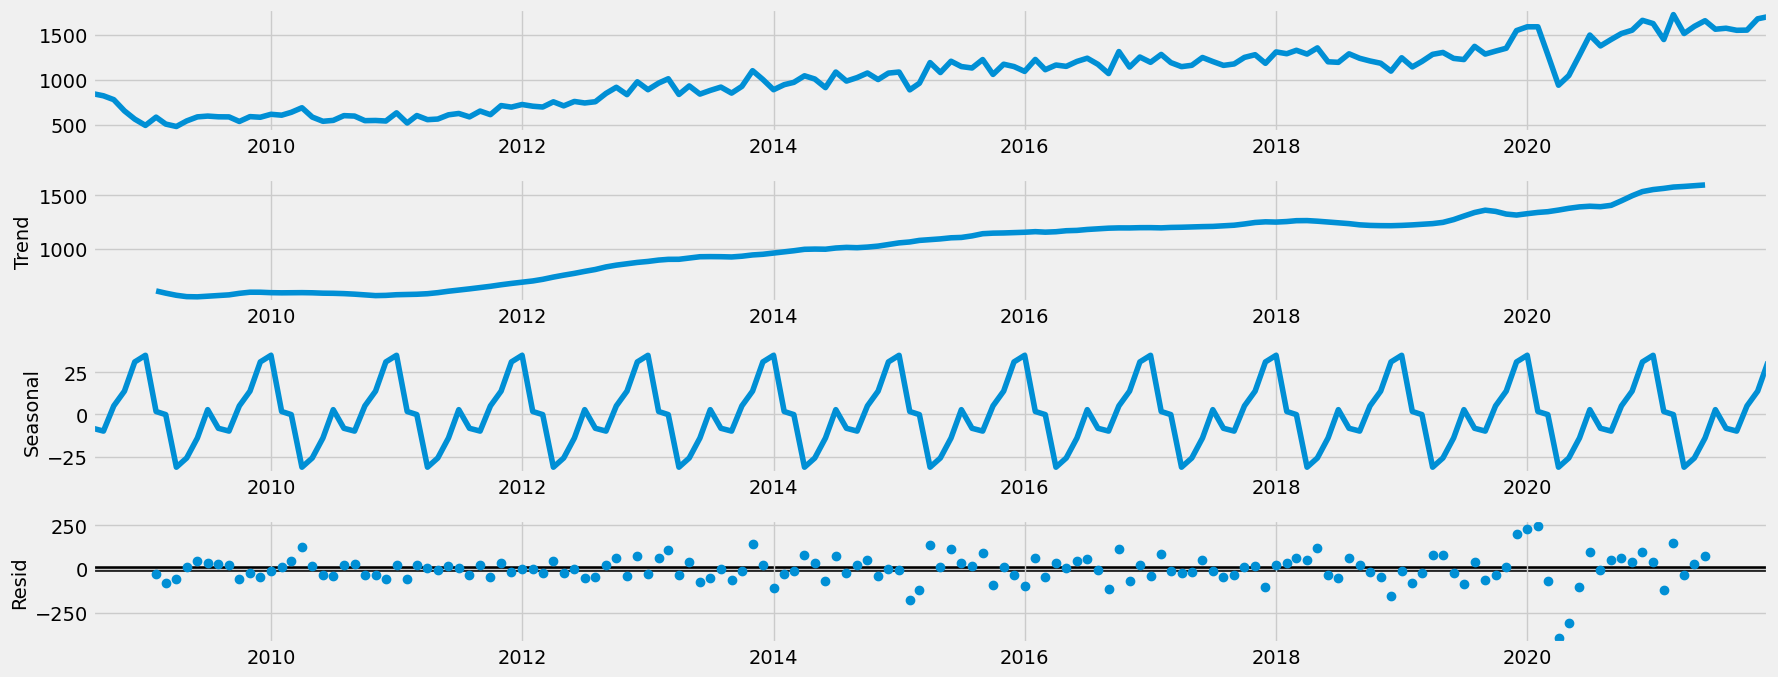

In [20]:
# plot separated components
decomposition.plot()
plt.show()

* Starting around 2009, there's a period of stability lasting until 2011. This likely links to the shaky economy following the 2008 global financial crisis. After that, the data consistently moves upwards, showing a positive trajectory. 

* We notice a pattern of ups and downs that happens every two years in the data. Recognizing this pattern can help us make informed predictions about future economic shifts.

* While we see certain trends, there's also some random fluctuation present in the data throughout. One interesting blip is around 2020, which aligns with the impact of the COVID-19 pandemic. This event caused a noticeable disruption in the economy. 

## TESTING FOR STATIONARITY

NULL HYPOTHESIS → Presence of a unit root (non-stationarity)

ALTERNATIVE HYPOTHESIS → Absence of a unit root (stationarity)

In [21]:
# define function to run dickey-fuller test

from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries): 

    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_sub['Value'])

Dickey-Fuller Stationarity test:
Test Statistic                   0.120447
p-value                          0.967430
Number of Lags Used              7.000000
Number of Observations Used    153.000000
Critical Value (1%)             -3.473830
Critical Value (5%)             -2.880623
Critical Value (10%)            -2.576945
dtype: float64


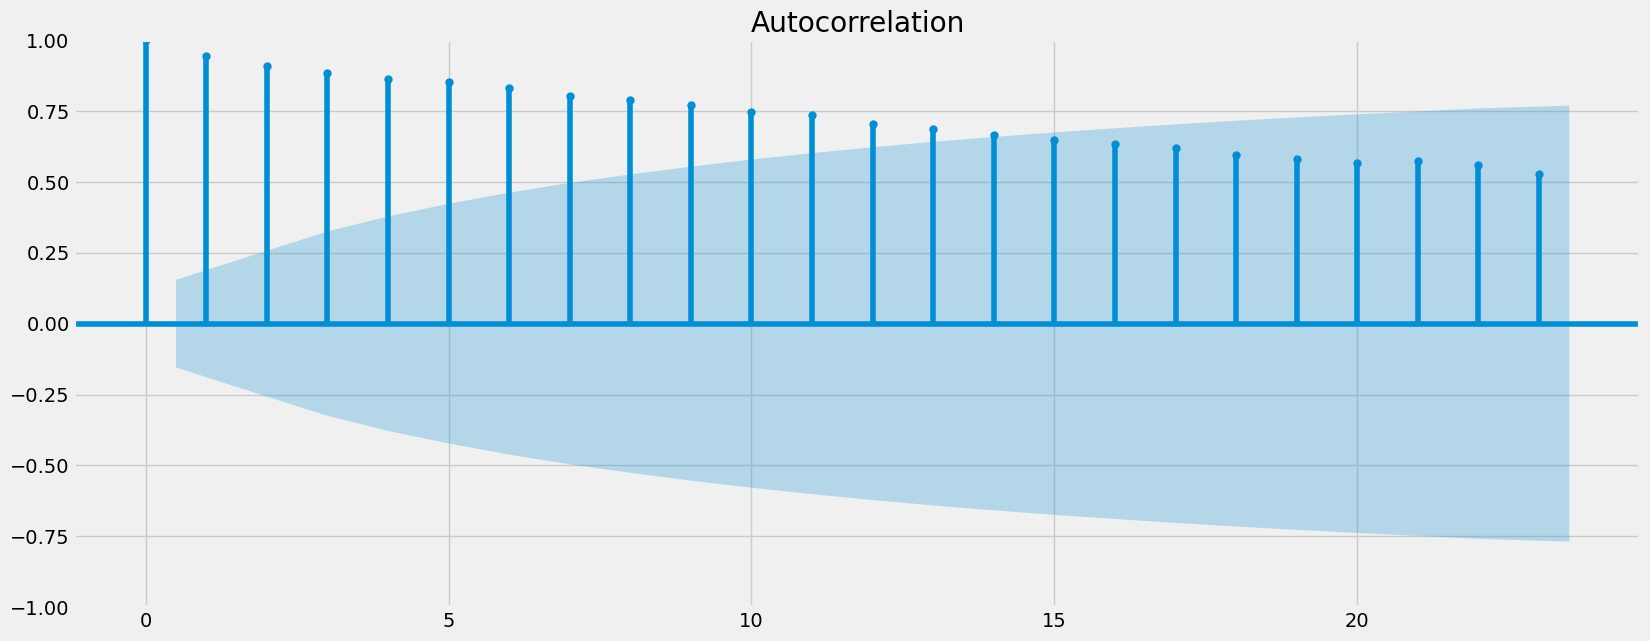

In [22]:
# generate autocorrelation plot

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(data_sub)
plt.show()

At a significance level of 5%, the Dickey-Fuller test fails to give us reason to reject the initial assumption. This outcome is driven by the test statistic significantly exceeding the Critical Value (5%). As a result, the evidence suggests the presence of a "unit root" in the data, implying that the data lacks stationarity. Furthermore, an examination of the autocorrelation plot reveals that a substantial number of the lags in the series exceed the confidence interval. This observation signifies a considerable amount of self-correlation within the data points. This aspect further reinforces the notion that the data lacks stability over the observed period.

## STATIONARIZATION

In [23]:
# stationarize time series using differencing method
data_diff = data_sub - data_sub.shift(1) # the df.shift(1) function turns the observation to t-1, making the whole thing t - (t-1)

In [24]:
# remove NaN values that resulted from differencing
data_diff.dropna(inplace = True)

In [25]:
# first 5 rows
data_diff.head()

,Value
datetime,
2008-09-01,-24.0
2008-10-01,-43.0
2008-11-01,-125.0
2008-12-01,-92.0
2009-01-01,-70.0


In [26]:
# DataFrame columns
data_diff.columns

Index(['Value'], dtype='object')

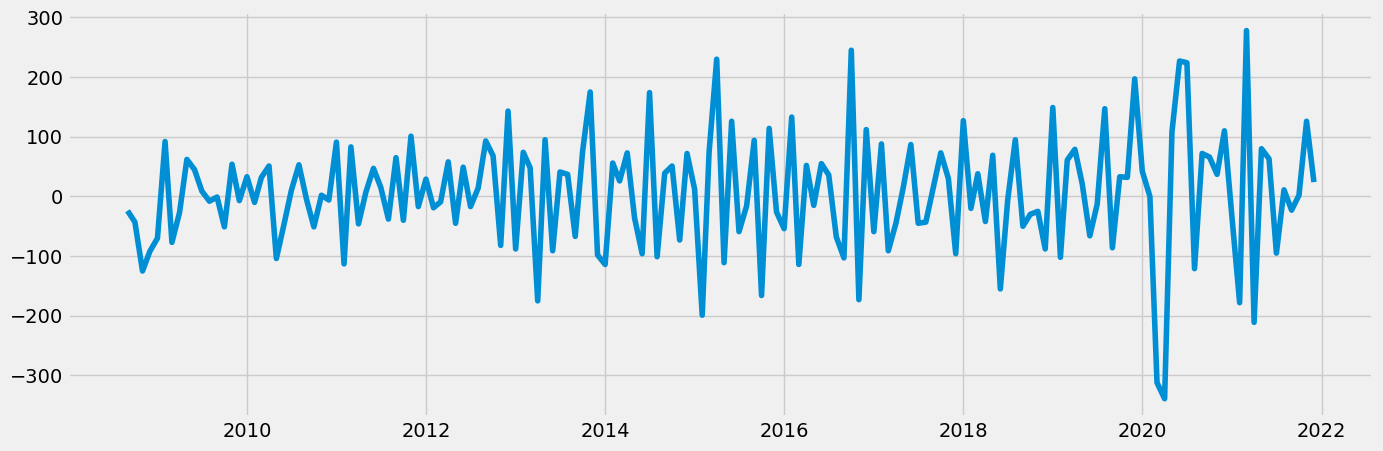

In [27]:
# plot data as line chart to visualize any changes that resulted from standarization
plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [28]:
# re-run dickey-fuller test to confirm non-stationarity
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                -7.669397e+00
p-value                        1.608649e-11
Number of Lags Used            6.000000e+00
Number of Observations Used    1.530000e+02
Critical Value (1%)           -3.473830e+00
Critical Value (5%)           -2.880623e+00
Critical Value (10%)          -2.576945e+00
dtype: float64


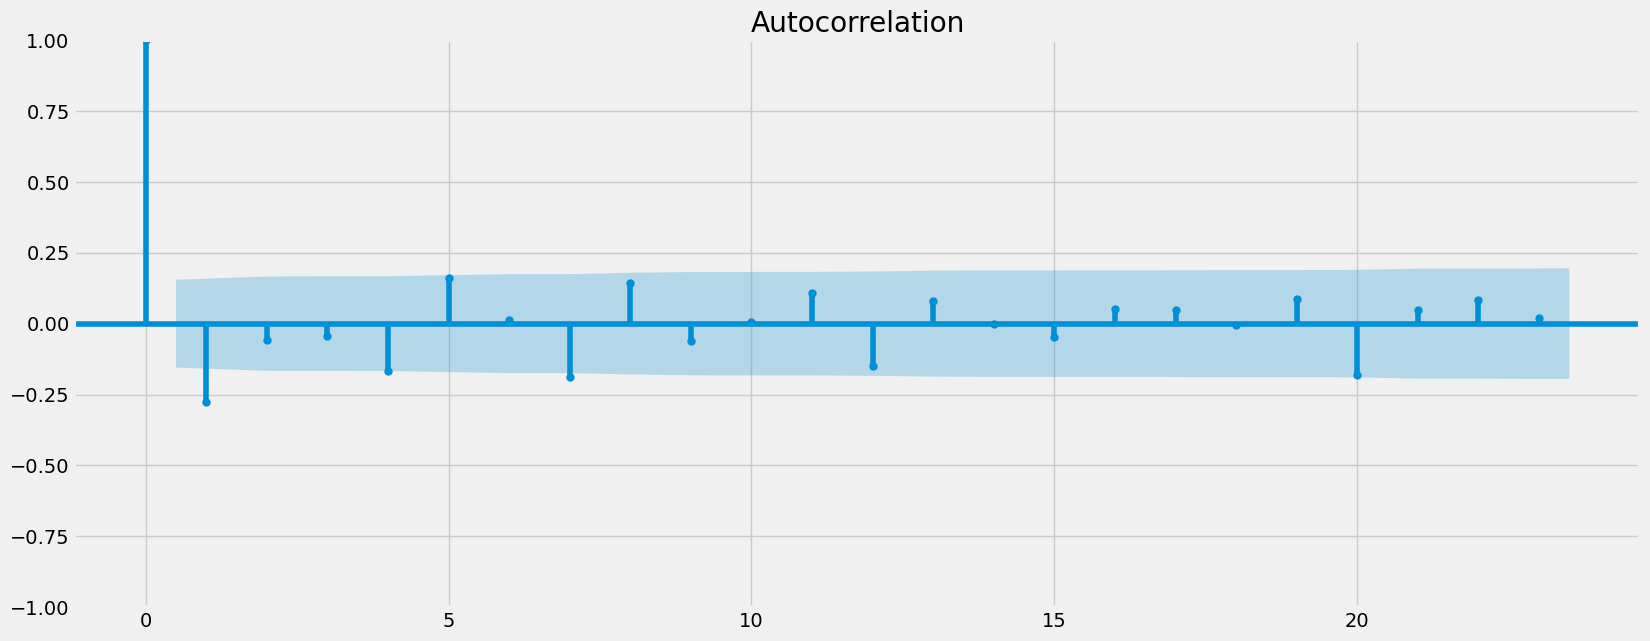

In [29]:
# generate autocorrelation plot with stationarized data
plot_acf(data_diff)
plt.show()

After applying a single round of differencing, the Dickey-Fuller test successfully rejects the null hypothesis. This is evident from the Test Statistic being lower than the Critical Value (5%). Additionally, when looking at the autocorrelation plot, we observe only a small number of lags exceeding the confidence interval. These observations collectively suggest that there's no need for further differencing of the data, indicating it has achieved stationarity and can now be regarded as stable for analysis.